
#### Problem 2\
<br>

Use a single, tree, Random Forests, and boosting to relate `y=price` to `x1=mileage` and `x2=year`.\

Use the three set approach, that is, split your data into tain, val, test.\

Plot your results.



In [2]:
### import

### basic 
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
#import tensorflow as tf

%matplotlib inline

##sklearn learners
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

##sklearn metrics
from sklearn.metrics import mean_squared_error

##sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#from tf.keras import models
#from tf.keras import layers
#from tf.keras import regularizers

## to visualize a tree
import pydotplus
from sklearn import tree
import os
import seaborn as sns; 

### random number generator
from numpy.random import default_rng



def myrmse(y,yhat):
   """ print out rmse with 3 digits"""
   rmse = math.sqrt(mean_squared_error(y,yhat))
   return(np.round(rmse,3))

#### Import the data

In [3]:
### read in boston data
cd = pd.read_csv("http://www.rob-mcculloch.org/data/usedcars.csv")

n = cd.shape[0] #sample size
p = cd.shape[1]-1
y = cd['price'].to_numpy()
x = cd[['mileage','year']].to_numpy()
#print('n,p: ',n,p)
print(x)


[[193296.   1995.]
 [129948.   1995.]
 [140428.   1997.]
 ...
 [ 47484.   2010.]
 [ 42972.   2010.]
 [ 46495.   2011.]]


#### Split the data into three sets: train, validation, and test

In [4]:
### train, val, test
rng = np.random.default_rng(seed=34)
ii = rng.choice(range(n),size=n,replace=False)

n1 = math.floor(n/2.0) # half the data in train
n2 = math.floor(n/4.0) # quarter of the data in train
n3 = n-n1-n2
ii1 = ii[:n1]; x1 = x[ii1]; y1 = y[ii1] #train
ii2 = ii[n1 + np.arange(n2)]; x2 = x[ii2]; y2 = y[ii2] #val
ii3 = ii[n1 + n2 + np.arange(n3)]; x3 = x[ii3]; y3 = y[ii3] #test

In [5]:
## let's test that the train/val/test split worked by recombining and comparing regression results
lmf = LinearRegression()
lmf.fit(x,y)
print(lmf.coef_)
xx = np.vstack([x1,x2,x3]); yy = np.concatenate([y1,y2,y3])
lmf.fit(xx,yy)
print(lmf.coef_)

[-1.40975174e-01  2.84935166e+03]
[-1.40975174e-01  2.84935166e+03]


####  Decision tree\
<br>
First fit on train and predict on val. The RMSE on the validation set is 6193.

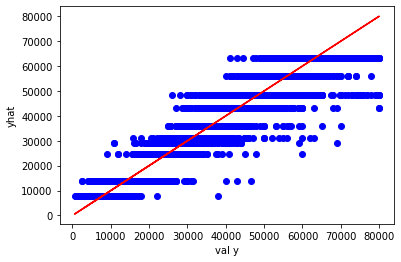

number of bottom  nodes:  10
rmse from desion tree, fit on train, predict on val:  6193.022


In [6]:
### simple decision tree

# tree with at most 10 bottom nodes
tmod = DecisionTreeRegressor(max_leaf_nodes=10)
tmod.fit(x1,y1)

## look at in-sample fits
yhat = tmod.predict(x2)

plt.scatter(y2,yhat,c='blue')
plt.xlabel('val y'); plt.ylabel('yhat')
plt.plot(y,y,c='red')
plt.show()
print("number of bottom  nodes: ",pd.Series(yhat).nunique())

print('rmse from desion tree, fit on train, predict on val: ',myrmse(y2,yhat))



#### Notice that the RMSE seems a large number because we did not rescale our data in this case. \
<br>
Next, we combine train and val and predict on test. The performance is not very different from above with RMSE=6210.

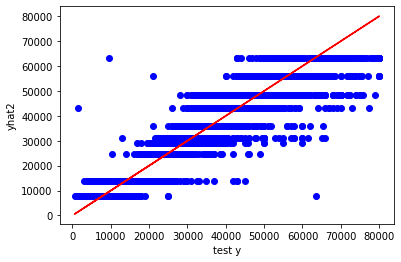

number of bottom  nodes:  10
rmse from rf, fit on train + val, predict on test:  6210.39


In [7]:
x12 = np.vstack([x1,x2]); y12 = np.concatenate([y1,y2])
tmod2 = DecisionTreeRegressor(max_leaf_nodes=10)
tmod2.fit(x12,y12)

## look at in-sample fits
yhat2 = tmod.predict(x3)

plt.scatter(y3,yhat2,c='blue')
plt.xlabel('test y'); plt.ylabel('yhat2')
plt.plot(y,y,c='red')
plt.show()
print("number of bottom  nodes: ",pd.Series(yhat).nunique())

print('rmse from rf, fit on train + val, predict on test: ',myrmse(y3,yhat2))



####  Random forest\
<br>
 We fit rf on train, predict on val. The RMSE is 6350.

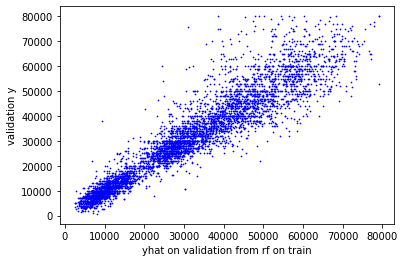

rmse from rf, fit on train, predict on val:  6350.174


In [8]:

# use 500 trees and 2 x's
rfm = RandomForestRegressor(random_state=0,n_jobs=-1,n_estimators=500,max_features=2)
rfm.fit(x1,y1) # fit on train
## predict on val
yhrf = rfm.predict(x2)

plt.scatter(yhrf,y2,c='blue',s=.5)
plt.xlabel('yhat on validation from rf on train');plt.ylabel('validation y')
plt.show()

print('rmse from rf, fit on train, predict on val: ',myrmse(y2,yhrf))



#### Combine train and val data to fit and predict on test\
<br>
The new RMSE is slightly larger with the test set, rmse=6430.

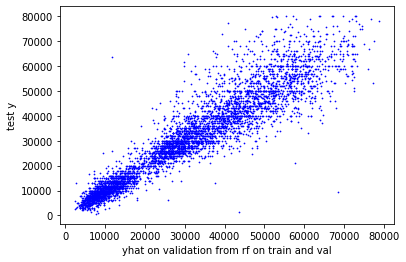

rmse from rf, fit on train and val, predict on test:  6430.478


In [9]:
## use train and val data
x12 = np.vstack([x1,x2]); y12 = np.concatenate([y1,y2])
rfm.fit(x12,y12)

yhrf2 = rfm.predict(x3)

plt.scatter(yhrf2,y3,c='blue',s=.5)
plt.xlabel('yhat on validation from rf on train and val');plt.ylabel('test y')
plt.show()

print('rmse from rf, fit on train and val, predict on test: ',myrmse(y3,yhrf2))


#### Boosting\
<br>
We first fit on train and predict on val. We see that predicting on the val, random forest gives a smaller RMSE than boosting and also shows greater correlation. 

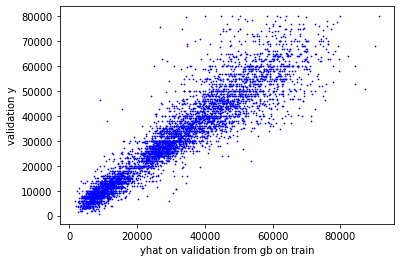

comparison of rf and bosting:
             y2      yhrf      yhgb
y2    1.000000  0.938049  0.927849
yhrf  0.938049  1.000000  0.969736
yhgb  0.927849  0.969736  1.000000
Slightly bigger correlation of random forest
rmse: rf, gb: 6350.174 6888.576


In [10]:
### try boosting
gbm = GradientBoostingRegressor(learning_rate=.2,n_estimators=5000,max_depth=4)
gbm.fit(x1,y1)
yhgb = gbm.predict(x2)

## plot boosting prediction on val
plt.scatter(yhgb,y2,c='blue',s=.5)
plt.xlabel('yhat on validation from gb on train');plt.ylabel('validation y')
plt.show()

## compare boosting to rf 
yhdf = pd.DataFrame({'y2':y2,'yhrf':yhrf,'yhgb':yhgb})
print('comparison of rf and bosting:\n',yhdf.corr())
print('Slightly bigger correlation of random forest')


print('rmse: rf, gb:',myrmse(y2,yhrf),myrmse(y2,yhgb))




#### Combine train and val and predict on test.\
<br>
The RMSE on the test set is 6706 which better than the validation set result.

rmse on test from gradient boosting:  6706.601


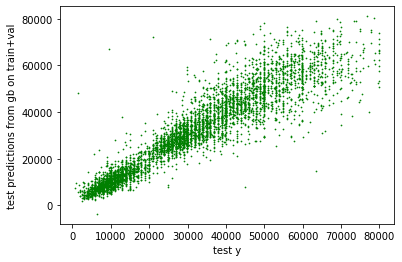

In [11]:
##################################################
### let's fit gb on train+val, predict on test

## use train and val data
gbm.fit(x12,y12)
yhgb3 = gbm.predict(x3)
print('rmse on test from gradient boosting: ',myrmse(y3,yhgb3))
#very similar to what we had before

## plot predictions on test
plt.scatter(y3,yhgb3,c='green',s=.5)
plt.xlabel('test y'); plt.ylabel('test predictions from gb on train+val')
plt.show()




